In [1]:
%pylab inline
# next 2 lines allow to automatically reload modules that have been changed externally
%reload_ext autoreload
%autoreload 2
import os, sys
sys.path.insert(0, '/nobackup/jakravit/smartg-dev/smartg/')
from luts.luts import LUT, MLUT, Idx, merge, read_mlut

from smartg.albedo import Albedo_spectrum, Albedo_speclib, Albedo_cst
from smartg.bandset import BandSet
from smartg.smartg import Smartg, Sensor, multi_profiles, reduce_diff
from smartg.smartg import RoughSurface, LambSurface, FlatSurface, Environment, multi_profiles
from smartg.atmosphere import AtmAFGL, AeroOPAC, CompOPAC, CloudOPAC, diff1, read_phase, Species, trapzinterp
from smartg.water import IOP_1, IOP, IOP_profile, IOP_Rw, IOP_base
from smartg.reptran import REPTRAN, reduce_reptran
#from smartg.kdis import KDIS, reduce_kdis
from smartg.tools.tools import SpherIrr, Irr, reduce_Irr
from smartg.tools.cdf import ICDF
from smartg.tools.phase import integ_phase, calc_iphase

from smartg.tools.smartg_view import compare, plot_polar, spectrum , mdesc 
from smartg.tools.smartg_view import spectrum_view,transect_view,profile_view,phase_view,smartg_view,input_view
import warnings

from scipy.interpolate import interp1d
warnings.filterwarnings("ignore")

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
from smartg_int_library import *
from build_Case2 import build_Case2
import numpy as np
from scipy.interpolate import interp1d
import pickle
import pandas as pd
import uuid
import time

In [3]:
import pickle
INFO = True
WAV = np.linspace(400, 900., num=201, dtype=np.float32)
WAV_CDOM = np.arange(240., 900., 2.5, dtype=np.float32)

# initiate iop dict
# iops, cols, row = build_Case2(phy_library, datamin, datadet, benthic_lib, adj_lib, aero_lib)
with open('/nobackup/jakravit/data/iops_test.p','rb') as fp:
    iops = pickle.load(fp)
    
if INFO:
    print ('Chla: {} ug/L'.format(iops['Phyto']['TotChl']))
    print ('Minl: {} g/L'.format(iops['Min']['Tot_conc']))
    print ('ag440: {} m^-1'.format(iops['CDOM']['ag440']))
    print ('Max Depth: {} m'.format(iops['Depth']['Dmax']))
    print ('Water radius: {} km'.format(iops['Adjacency']['water_radius']))
    print ('Dist from shore: {} km'.format(iops['Adjacency']['dist']))

Chla: 12.062 ug/L
Minl: 3.1160428571428573 g/L
ag440: 1.16 m^-1
Max Depth: 13.5 m
Water radius: 2 km
Dist from shore: 0.5 km


In [23]:
# get mixing IOP's
ap1,ac1,bp1,vsf1,angles = mix(iops)
# aw, bw = read_awbw(aux_dir, WAV)

# wavelength grid/slice for absorption and scattering coefficients
# wavelength grid for outputs
wavrange = slice(0,202,2)
wav      = WAV[wavrange]
# wav      = np.arange(400,905,5)
# wavelength grid/slice for scattering matrices
wavrange_vsf = slice(0,200,50)
wav_vsf      = WAV[wavrange_vsf]
# vertical grid
Z = iops['Depth']['Depth']
# Z   = np.array([0, -2.5, -5., -10.])
xfactor = iops['Depth']['xfactor']
zeros = np.zeros_like(wav)

#IOP's profiles
bp_list = [bp1[wavrange] * x for x in xfactor] 
ap_list = [ap1[wavrange] * x for x in xfactor]
ac_list = [ac1[wavrange] * x for x in xfactor]
xfactorvsf = [1 if x==0 else x for x in xfactor]
vsf_list = [vsf1[:,wavrange_vsf,:] * x for x in xfactorvsf]
# aw_list = [aw[wavrange]] * len(xfactor)
# bw_list = [bw[wavrange]] * len(xfactor)
aw_list = None # use SMART-G default pure water absorption
bw_list = None # use SMART-G default pure water scattering

# Albedos speclib library inputs    
bALB = Albedo_spectrum2(iops['Benthic']['Tot'])
aALB = Albedo_speclib2(iops['Adjacency']['Tot'])

# water MLUT building
# VSF truncation at 10 deg
# seafloor from mixing model
water   = import_iop(ap_list, bp_list, ac_list, vsf_list, wav, wav_vsf, Z, angles, 
                    aw_list=aw_list, bw_list=bw_list, ang_trunc=25, ALB=bALB).describe()


 Datasets:
  [0] T_oc (float32 in [280, 280]), axes=('z_oc',)
  [1] phase_oc (float64 in [0, 11.7]), axes=('iphase', 'stk', 'theta_oc')
  [2] iphase_oc (int32 in [0, 111]), axes=('wavelength', 'z_oc')
  [3] OD_w (float64 in [-90.5, 0]), axes=('wavelength', 'z_oc')
  [4] OD_p_oc (float64 in [-30, 0]), axes=('wavelength', 'z_oc')
  [5] OD_y (float64 in [-215, 0]), axes=('wavelength', 'z_oc')
  [6] OD_oc (float64 in [-241, 0]), axes=('wavelength', 'z_oc')
  [7] OD_sca_oc (float64 in [-20.9, 0]), axes=('wavelength', 'z_oc')
  [8] OD_abs_oc (float64 in [-226, 0]), axes=('wavelength', 'z_oc')
  [9] pine_oc (float64 in [0, 0]), axes=('wavelength', 'z_oc')
  [10] pmol_oc (float32 in [0.000197, 1]), axes=('wavelength', 'z_oc')
  [11] ssa_oc (float64 in [0.0633, 1]), axes=('wavelength', 'z_oc')
  [12] ssa_p_oc (float32 in [0.589, 1]), axes=('wavelength', 'z_oc')
  [13] ssa_w (float64 in [3.46e-05, 1]), axes=('wavelength', 'z_oc')
  [14] FQY1_oc (float64 in [0, 0]), axes=('wavelength', 'z_oc')
  

In [24]:
# Ocean surface
surf=RoughSurface(WAVE_SHADOW=True, WIND=iops['Atm']['wind'])

# Land environment
D       = iops['Adjacency']['water_radius'] #(km)
# The Environement object creates a disk of ocean surface with radius ENV_SIZE
# centred on X0,Y0 , surrounded by lambertian reflector of albedo ALB
env     = Environment(ENV=1, 
                      ENV_SIZE= D ,       # radius of the circle with ocean surface condition
                      X0= -D,             # X coordinate of the center of the circle
                      Y0= 0,
                      ALB=aALB # adjacency mixing model
                     )

#Observer
HTOA   = 120.
VZA    = iops['Atm']['VZA']
VAA    = iops['Atm']['VAA']
dist   = iops['Adjacency']['dist'] # distance to the coast(km)
DeltaH = HTOA   * np.tan(np.radians(VZA))
DeltaX = DeltaH * np.cos(np.radians(180-VAA))
DeltaY = DeltaH * np.sin(np.radians(180-VAA))
sensor_TOA = Sensor(
    POSX = -dist + DeltaX,      # Sensor coordinates (in km) (default:origin(0.,0.,0.))
    POSY = DeltaY,
    POSZ = HTOA,
    THDEG= 180-VZA, # Sensor 'Emitting' zenith angle, from 0: Zenith to 180.: Nadir (default:0.)
    PHDEG= VAA,     # Sensor 'Emitting' azimuth angle (default:0.)
    LOC  = 'ATMOS', # location of sensor (default: (SURF0P, just above surface)
    FOV  = 0.,      # Sensor FOV (default 0.)
    TYPE = 0        # Sensor type :Radiance (0), Planar flux (1), Spherical Flux (2), (default 0)
    )
sensor_BOA = Sensor(THDEG=180-VZA, PHDEG=VAA, TYPE=0, LOC='ATMOS')

# Atmosphere
# to be computed at eh same wavlegnth grid as water IOP's

# monochromatic computation for custom aerosols and cloud
wlref = 440.
# Aerosols and cloud optical properties using OPAC database as processed by the the libradtran (www.libradtran.org)
aer = AeroOPAC( iops['Atm']['aero_prof'], 
                iops['Atm']['aero'].loc[:,'AOD_Coincident_Input[440nm]'].values, 
                wlref,
                ssa = iops['Atm']['aero'].loc[:,'Single_Scattering_Albedo[440nm]'].values
              ) 


atm = AtmAFGL(atm_filename = iops['Atm']['atm_prof'],    # atmosphere profile
              comp=[aer], # no clouds, only aerosols          
              #O3 = 0.,   # scale ozone vertical column to 0 Dobson units (here no absoprtion by ozone)
              #NO2= False,# disable absorption by NO2
              #H2O= 2.,   # scale water vapour column to 2 g/cm-2, but no H2O absoprtion, just hygroscopic computation for aerosols
              #P0 = 980., # set sea level pressure to 980 hPa
              #tauR=0.1,   # force Rayleigh optical thickness
              #grid =   [100., 75., 50., 25., 15., 10., 5., 3., 2., 1.15], # set vertical grid, surface altitude at 1.15 km
              #pfgrid = [100., 25., 15., 10., 5., 3., 2., 1.15], # vertical grid for the computation of particles phase functions
              pfwav=wav_vsf
             ).calc(wav).describe()


 Datasets:
  [0] n_atm (float64 in [1, 1]), axes=('wavelength', 'z_atm')
  [1] T_atm (float32 in [177, 380]), axes=('z_atm',)
  [2] OD_r (float64 in [2.68e-10, 0.36]), axes=('wavelength', 'z_atm')
  [3] OD_p (float32 in [0, 0.836]), axes=('wavelength', 'z_atm')
  [4] ssa_p_atm (float32 in [0.978, 1]), axes=('wavelength', 'z_atm')
  [5] OD_g (float64 in [-0, 0.0423]), axes=('wavelength', 'z_atm')
  [6] OD_atm (float64 in [2.68e-10, 1.2]), axes=('wavelength', 'z_atm')
  [7] OD_sca_atm (float64 in [0, 1.18]), axes=('wavelength', 'z_atm')
  [8] OD_abs_atm (float64 in [0, 0.0534]), axes=('wavelength', 'z_atm')
  [9] ssa_atm (float64 in [0.0476, 1]), axes=('wavelength', 'z_atm')
  [10] pmol_atm (float64 in [0.00858, 1]), axes=('wavelength', 'z_atm')
  [11] pine_atm (float64 in [0, 0]), axes=('wavelength', 'z_atm')
  [12] FQY1_atm (float64 in [0, 0]), axes=('wavelength', 'z_atm')
  [13] phase_atm (float64 in [-0.315, 115]), axes=('iphase', 'stk', 'theta_atm')
  [14] iphase_atm (int32 in [0, 3

In [25]:
le = {'th_deg':np.linspace(30,60,num=2), 'phi_deg':np.linspace(0,360,num=4)}
alis = True
alis_options = {'nlow':-1}
SMa = Smartg(device=0, back=True, alt_pp=True, alis=alis)
SM  = Smartg(device=0, back=True, alt_pp=True)

In [27]:
%%time
mBa  = SMa.run(wl=wav, water=water, atm=atm, surf=surf, NBPHOTONS=1e4, env=env,
             sensor=sensor_TOA, NF=1e3, alis_options=alis_options, le=le, OUTPUT_LAYERS=3,)

Box(children=(FloatProgress(value=0.0, max=10000.0), Label(value='')), layout=Layout(align_items='center', dis…

CPU times: user 591 ms, sys: 401 ms, total: 991 ms
Wall time: 992 ms


In [26]:
%%time
mBa2  = SMa.run(wl=wav, water=water, atm=atm, surf=surf, NBPHOTONS=1e4,
             sensor=sensor_TOA, NF=1e3, alis_options=alis_options, le=le, OUTPUT_LAYERS=3,)

Box(children=(FloatProgress(value=0.0, max=10000.0), Label(value='')), layout=Layout(align_items='center', dis…

CPU times: user 22.2 s, sys: 17.5 s, total: 39.7 s
Wall time: 39.8 s


In [14]:
%%time
mB  = SM.run(wl=wav, water=water, atm=atm, surf=surf, NBPHOTONS=1e6, env=env,
             sensor=sensor_TOA, NF=1e3, le=le, OUTPUT_LAYERS=3,)

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

CPU times: user 280 ms, sys: 128 ms, total: 408 ms
Wall time: 404 ms


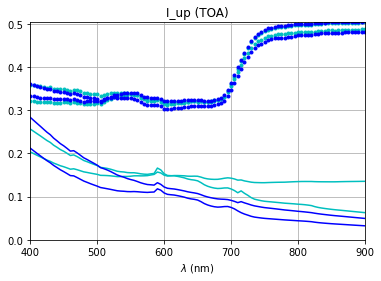

In [28]:
lut1_90 = mBa ['I_up (TOA)'].sub({'Zenith angles':Idx([30,60]), 'Azimuth angles':Idx(90)})
lut1_0  = mBa ['I_up (TOA)'].sub({'Zenith angles':Idx([30,60]), 'Azimuth angles':Idx(0)})
lut2_90 = mBa2['I_up (TOA)'].sub({'Zenith angles':Idx([30,60]), 'Azimuth angles':Idx(90)})
lut2_0  = mBa2['I_up (TOA)'].sub({'Zenith angles':Idx([30,60]), 'Azimuth angles':Idx(0)})
f = figure()
spectrum(lut1_90, vmin=0, vmax=None, sub=111,  fig=f, color='c', percent=False, fmt='.')
spectrum(lut1_0,  vmin=0, vmax=None, sub=None, fig=f, color='b', percent=False, fmt='.')
spectrum(lut2_90, vmin=0, vmax=None, sub=None, fig=f, color='c', percent=False, fmt='-')
spectrum(lut2_0,  vmin=0, vmax=None, sub=None, fig=f, color='b', percent=False, fmt='-')

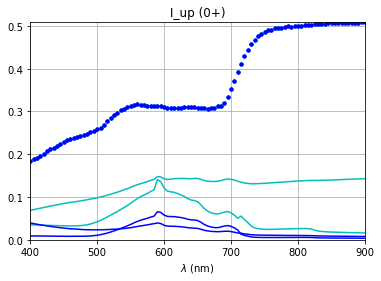

In [29]:
lut1_90 = mBa ['I_up (0+)'].sub({'Zenith angles':Idx([30,60]), 'Azimuth angles':Idx(90)})
lut1_0  = mBa ['I_up (0+)'].sub({'Zenith angles':Idx([30,60]), 'Azimuth angles':Idx(0)})
lut2_90 = mBa2['I_up (0+)'].sub({'Zenith angles':Idx([30,60]), 'Azimuth angles':Idx(90)})
lut2_0  = mBa2['I_up (0+)'].sub({'Zenith angles':Idx([30,60]), 'Azimuth angles':Idx(0)})
f = figure()
spectrum(lut1_90, vmin=0, vmax=None, sub=111,  fig=f, color='c', percent=False, fmt='.')
spectrum(lut1_0,  vmin=0, vmax=None, sub=None, fig=f, color='b', percent=False, fmt='.')
spectrum(lut2_90, vmin=0, vmax=None, sub=None, fig=f, color='c', percent=False, fmt='-')
spectrum(lut2_0,  vmin=0, vmax=None, sub=None, fig=f, color='b', percent=False, fmt='-')

In [16]:
mB.describe()

 Datasets:
  [0] I_up (TOA) (float64 in [0.299, 0.51]), axes=('wavelength', 'Azimuth angles', 'Zenith angles')
  [1] Q_up (TOA) (float64 in [-0.095, 0.0775]), axes=('wavelength', 'Azimuth angles', 'Zenith angles')
  [2] U_up (TOA) (float64 in [-0.05, 0.0484]), axes=('wavelength', 'Azimuth angles', 'Zenith angles')
  [3] V_up (TOA) (float64 in [-0.000366, 0.000399]), axes=('wavelength', 'Azimuth angles', 'Zenith angles')
  [4] N_up (TOA) (uint64 in [5.16e+04, 1.47e+05]), axes=('wavelength', 'Azimuth angles', 'Zenith angles')
  [5] I_down (0+) (float64 in [0.124, 1.28]), axes=('wavelength', 'Azimuth angles', 'Zenith angles')
  [6] Q_down (0+) (float64 in [-0.0229, 0.0374]), axes=('wavelength', 'Azimuth angles', 'Zenith angles')
  [7] U_down (0+) (float64 in [-0.0649, 0.0471]), axes=('wavelength', 'Azimuth angles', 'Zenith angles')
  [8] V_down (0+) (float64 in [-0.000248, 0.000207]), axes=('wavelength', 'Azimuth angles', 'Zenith angles')
  [9] N_down (0+) (uint64 in [2.43e+04, 1.18e+05])